In [1]:
import sys
sys.path.append('C:\\Users\\DavidB\\PycharmProjects\\My_Football_Analytics\\Basics')
sys.path.append('C://Users//DavidB//PycharmProjects//My_Football_Analytics//Position_data')

import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus
import Data.Metrica_IO as mio
from Tracking_Data import tracking_data
import pitch_control
import matplotlib.pyplot as plt
import pitch_control as pi_co

away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

# positions of players and ball as numpy.ndarray
locs_home = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([120,80])
locs_away = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([120,80])
locs_ball = np.asarray(home_data.iloc[:,range(31,33)]) * np.array([120,80])

# time colum as pandas.core.series.Series
tt = home_data['Time [s]']

# event data dataframe
# event_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv')


In [2]:
# supposed to be based on td_object --> first create one
# everywhere we call the object now will later be self

data_dir = 'sample-data-master/data/'
game_id = 1
away = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Away')
home = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Home')
td = mio.merge_tracking_data(home, away)
td_object = tracking_data(td, data_source='metrica', scale_to_pitch='mplsoccer')
td_object.get_velocities()

td_object

Reading team: away
Reading team: home


In [3]:
jitter = 1e-12 # to avoid division by zero when players are standing still

# convert to tensor (n_players, n_frames, 2)
# GPU versions of data if available via cuda function
# all frames
xy_home = torch.Tensor(locs_home)
xy_away = torch.Tensor(locs_away)
xy_ball = torch.Tensor(locs_ball)
ttt = torch.Tensor(tt.values)

# x & y velocity components
# removes first frame for some reason
dt = ttt[1:] - ttt[:-1]
# frame :-1
sxy_home = (xy_home[:,1:,:] - xy_home[:,:-1,:])/dt[:,None] + jitter
sxy_away = (xy_away[:,1:,:] - xy_away[:,:-1,:])/dt[:,None] + jitter

# frame :-1
# speed via pythagoras for each x-y-combination (=dimension 2)
s_home = torch.sqrt(torch.sum(sxy_home**2,2))
s_away = torch.sqrt(torch.sum(sxy_away**2,2))

# frame :-1
# angles of travel
theta_home = torch.acos(sxy_home[:,:,0] / s_home)
theta_away = torch.acos(sxy_away[:,:,0] / s_away)


# frame :-1
# means for player influence functions (mu)
# gamma = 0.5
mu_home = xy_home[:,:-1,:] + 0.5*sxy_home
mu_away = xy_away[:,:-1,:] + 0.5*sxy_away


# frame :-1
# proportion of max. speed
# max speed = 13m/s
# maximal rate of 1 (i.e. excluding faster than assumed max speed
# according to Fernandez (2018) eq. (18) this is not correct
Srat_home = torch.min((s_home / 13.0)**2,torch.Tensor([1]))
Srat_away = torch.min((s_away / 13.0)**2,torch.Tensor([1]))

# all frames
# influence radius
Ri_home = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_home)**2,2))**3 / 972,torch.Tensor([10]))
Ri_away = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_away)**2,2))**3 / 972,torch.Tensor([10]))

# inverses of covariance matrices -- Sigma^{-1} = RS^{-1}S^{-1}R^T. only need RS^{-1} to evaluate gaussian.

# all frames
# create tensor with zeros to be filled
RSinv_home = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)
RSinv_away = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)

# frame :-1
# s for S matrix
S1_home = 2 / ((1+Srat_home) * Ri_home[:,:-1])
S2_home = 2 / ((1-Srat_home) * Ri_home[:,:-1])
S1_away = 2 / ((1+Srat_away) * Ri_away[:,:-1])
S2_away = 2 / ((1-Srat_away) * Ri_away[:,:-1])

# frame :-1
# RS^-1 as the sum of S and the angle from R (A) 
RSinv_home[:,:,0,0] = S1_home * torch.cos(theta_home)
RSinv_home[:,:,1,0] = S1_home * torch.sin(theta_home)
RSinv_home[:,:,0,1] = - S2_home * torch.sin(theta_home)
RSinv_home[:,:,1,1] = S2_home * torch.cos(theta_home)

RSinv_away[:,:,0,0] = S1_away * torch.cos(theta_away)
RSinv_away[:,:,1,0] = S1_away * torch.sin(theta_away)
RSinv_away[:,:,0,1] = - S2_away * torch.sin(theta_away)
RSinv_away[:,:,1,1] = S2_away * torch.cos(theta_away)

# frame :-1
# denominators for individual player influence functions (see eq 1 in paper). Note the normalising factors 
# for the multivariate normal distns (eq 12) 
#cancel, so don't need to bother computing them.
denominators_h = torch.exp(-0.5 * torch.sum(((xy_home[:,:-1,None,:] - mu_home[:,:,None,:]).matmul(RSinv_home))**2,-1))
denominators_a = torch.exp(-0.5 * torch.sum(((xy_away[:,:-1,None,:] - mu_away[:,:,None,:]).matmul(RSinv_away))**2,-1))


# set up query points for evaluating pitch control
n_grid_points_x = 50
n_grid_points_y = 30
xy_query = torch.stack([torch.linspace(0,120,n_grid_points_x).repeat(n_grid_points_y),torch.repeat_interleave(torch.linspace(0, 80,n_grid_points_y),n_grid_points_x)],1)
     

In [4]:
# specify frames of interest
first_frame = 0
#n_frames = sxy_home.shape[1]
n_frames = 250

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
# all target locations for all frames
pitch_control = torch.Tensor(n_frames,xy_query.shape[0])

#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 250

for f in range(int(n_frames/batch_size)):
    print(f)
    # substract means from query points = p-mu
    # but this is mu - p
    xminmu_h = mu_home[:,(first_frame + f*batch_size):
                       (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    # multiply (mu - x) obtained above by RS^{-1}
    mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):
                                      (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    # mm_h = (p-mu) * RS^-1
    # infl_h = mm_h^2 = ((p-mu) * RS^-1)^2 = (p-mu) * RS^-1 * (p-mu) * RS^-1) = (p-mu) * SIGMA * (p-mu)
    infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
    # infl_h = exponent of f
    infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):
                                     (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
    infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    # missing values --> 0
    isnan_h = torch.isnan(infl_h)
    isnan_a = torch.isnan(infl_a)
    infl_h[isnan_h] = 0
    infl_a[isnan_a] = 0
    
    # frame :-1
    # based on both teams influence areas we calculate the pitch control by transforming the delta into
    # a probability via the sigmoid function
    pitch_control[(f*batch_size):
                  (np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sigmoid(torch.sum(infl_h,0) - torch.sum(infl_a,0))




0


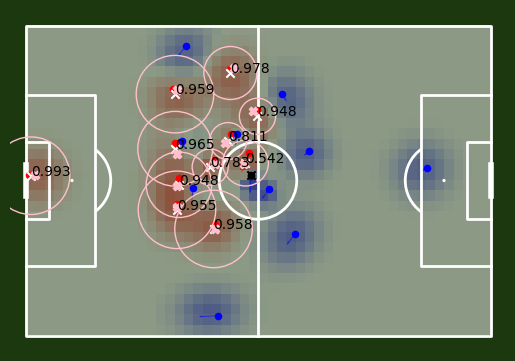

In [5]:
import matplotlib.pyplot as plt
f = 100
fig, ax = td_object.plot_players(frame=f, velocities=True)


ax.imshow(pitch_control[f].reshape(n_grid_points_y,n_grid_points_x),extent = (0,120, 80, 0), 
          cmap='bwr', alpha=0.5, vmin=0.0, vmax=1.0)
ax.scatter(mu_home[:, f, 0], mu_home[:, f, 1], marker='x', color = 'white')
ax.scatter(xy_ball[f, 0], xy_ball[f,1], color='black', marker='x')
for p in range(len(Ri_home)):
    if mu_home[p, f, 0].item() > -1. and mu_home[p, f, 1].item() > -1.:
        cir = plt.Circle((mu_home[p, f, 0], mu_home[p, f, 1]), fill=False, radius = Ri_home[p, 0], color='pink')
        ax.add_patch(cir)
        ax.text(mu_home[p, f, 0], mu_home[p, f, 1], s=str(round(denominators_h[p,f].item(), 3)))
        i = infl_h[p, f, :].argmax()
        ax.scatter(xyq[:, :, i][0][0][0], xyq[:, :, i][0][0][1], color='pink', marker='X')

In [6]:
jitter=1e-12
pos_nan_to=-1000
vel_nan_to=0

tt = td_object.data['Time [s]']

# access position data
Home = td_object.get_team('Home', selection='position', T_P=False)
Away = td_object.get_team('Away', selection='position', T_P=False)
Ball = td_object.get_ball(pos_only=True)

# access velocities
vel_Home = td_object.get_team('Home', selection='velocity', T_P=False)
vel_Away = td_object.get_team('Away', selection='velocity', T_P=False)

# convert to arrays
Ball_array = pi_co.pos_to_array(Ball, nan_to=np.nan, ball=True, Fernandez=True)
Home_array = pi_co.pos_to_array(Home, nan_to=pos_nan_to)
Away_array = pi_co.pos_to_array(Away, nan_to=pos_nan_to)
Home_vel_array = pi_co.pos_to_array(vel_Home, nan_to=vel_nan_to) + jitter
Away_vel_array = pi_co.pos_to_array(vel_Away, nan_to=vel_nan_to) + jitter

xy_home = torch.Tensor(Home_array)
xy_away = torch.Tensor(Away_array)
xy_ball = torch.Tensor(Ball_array)
sxy_home = torch.Tensor(Home_vel_array)
sxy_away = torch.Tensor(Away_vel_array)

ttt = torch.Tensor(tt.values)
dt = ttt[1:] - ttt[:-1]

# speed via pythagoras for each x-y-combination (=dimension 2)
s_home = torch.sqrt(torch.sum(sxy_home**2,2))
s_away = torch.sqrt(torch.sum(sxy_away**2,2))

# angles of travel
theta_home = torch.acos(sxy_home[:,:,0] / s_home)
theta_away = torch.acos(sxy_away[:,:,0] / s_away)

# means for player influence functions (mu)
# gamma = 0.5
mu_home = xy_home[:,:,:] + 0.5*sxy_home
mu_away = xy_away[:,:,:] + 0.5*sxy_away

# proportion of max. speed
# max speed = 13m/s
# maximal rate of 1 (i.e. excluding faster than assumed max speed
# according to Fernandez (2018) eq. (18) this is not correct
Srat_home = torch.min((s_home / 13.0)**2,torch.Tensor([1]))
Srat_away = torch.min((s_away / 13.0)**2,torch.Tensor([1]))

# influence radius
Ri_home = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_home)**2,2))**3 / 972,torch.Tensor([10]))
Ri_away = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_away)**2,2))**3 / 972,torch.Tensor([10]))

# inverses of covariance matrices -- Sigma^{-1} = RS^{-1}S^{-1}R^T. only need RS^{-1} to evaluate gaussian.

# create tensor with zeros to be filled
RSinv_home = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)
RSinv_away = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)

# s for S matrix
S1_home = 2 / ((1+Srat_home) * Ri_home[:,:])
S2_home = 2 / ((1-Srat_home) * Ri_home[:,:])
S1_away = 2 / ((1+Srat_away) * Ri_away[:,:])
S2_away = 2 / ((1-Srat_away) * Ri_away[:,:])

# RS^-1 as the sum of S and the angle from R (A) 
RSinv_home[:,:,0,0] = S1_home * torch.cos(theta_home)
RSinv_home[:,:,1,0] = S1_home * torch.sin(theta_home)
RSinv_home[:,:,0,1] = - S2_home * torch.sin(theta_home)
RSinv_home[:,:,1,1] = S2_home * torch.cos(theta_home)

RSinv_away[:,:,0,0] = S1_away * torch.cos(theta_away)
RSinv_away[:,:,1,0] = S1_away * torch.sin(theta_away)
RSinv_away[:,:,0,1] = - S2_away * torch.sin(theta_away)
RSinv_away[:,:,1,1] = S2_away * torch.cos(theta_away)
# denominators for individual player influence functions (see eq 1 in paper). Note the normalising factors 
# for the multivariate normal distns (eq 12) 
#cancel, so don't need to bother computing them.
denominators_h = torch.exp(-0.5 * torch.sum(((xy_home[:,:,None,:] - mu_home[:,:,None,:]).matmul(RSinv_home))**2,-1))
denominators_a = torch.exp(-0.5 * torch.sum(((xy_away[:,:,None,:] - mu_away[:,:,None,:]).matmul(RSinv_away))**2,-1))


# set up query points for evaluating pitch control
n_grid_points_x = 120
n_grid_points_y = 80
xy_query = torch.stack([torch.linspace(0,120,n_grid_points_x).repeat(n_grid_points_y),torch.repeat_interleave(torch.linspace(0, 80,n_grid_points_y),n_grid_points_x)],1)
     

In [7]:
# specify frames of interest
first_frame = 0
#n_frames = sxy_home.shape[1]
n_frames = 250

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
# all target locations for all frames
pitch_control = torch.Tensor(n_frames,xy_query.shape[0])

#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 250

for f in range(int(n_frames/batch_size)):
    print(f)
    # substract means from query points = p-mu
    # but this is mu - p
    xminmu_h = mu_home[:,(first_frame + f*batch_size):
                       (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    # multiply (mu - x) obtained above by RS^{-1}
    mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):
                                      (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    # mm_h = (p-mu) * RS^-1
    # infl_h = mm_h^2 = ((p-mu) * RS^-1)^2 = (p-mu) * RS^-1 * (p-mu) * RS^-1) = (p-mu) * SIGMA * (p-mu)
    infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
    # infl_h = exponent of f
    infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):
                                     (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
    infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    # missing values --> 0
    isnan_h = torch.isnan(infl_h)
    isnan_a = torch.isnan(infl_a)
    infl_h[isnan_h] = 0
    infl_a[isnan_a] = 0
    
    
    # based on both teams influence areas we calculate the pitch control by transforming the delta into
    # a probability via the sigmoid function
    pitch_control[(f*batch_size):
                  (np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sigmoid(torch.sum(infl_h,0) - torch.sum(infl_a,0))




0


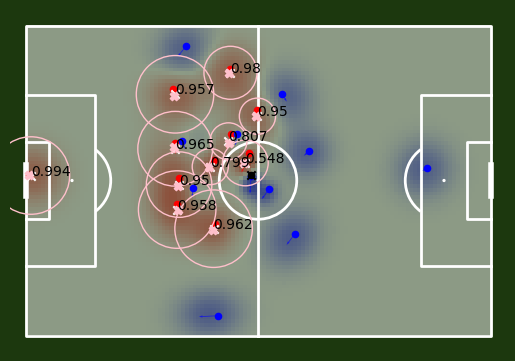

In [8]:
import matplotlib.pyplot as plt
f = 100

fig, ax = td_object.plot_players(frame=f, velocities=True)


ax.imshow(pitch_control[f].reshape(n_grid_points_y,n_grid_points_x),extent = (0,120, 80, 0), 
          cmap='bwr', alpha=0.5, vmin=0.0, vmax=1.0)
ax.scatter(mu_home[:, f, 0], mu_home[:, f, 1], marker='x', color = 'white')
ax.scatter(xy_ball[f, 0], xy_ball[f,1], color='black', marker='x')
for p in range(len(Ri_home)):
    if mu_home[p, f, 0].item() > -1. and mu_home[p, f, 1].item() > -1.:
        cir = plt.Circle((mu_home[p, f, 0], mu_home[p, f, 1]), fill=False, radius = Ri_home[p, 0], color='pink')
        ax.add_patch(cir)
        ax.text(mu_home[p, f, 0], mu_home[p, f, 1], s=str(round(denominators_h[p,f].item(), 3)))
        i = infl_h[p, f, :].argmax()
        ax.scatter(xyq[:, :, i][0][0][0], xyq[:, :, i][0][0][1], color='pink', marker='X')
        # consider that these are placed on the top left of the grid cell with max value! --> inaccuracy
        


In [9]:
control = pi_co.tensor_pitch_control(td_object=td_object, version = 'Fernandez')

Current batch: 1/2
Current batch: 2/2


In [10]:
pitch_control.shape

torch.Size([250, 9600])

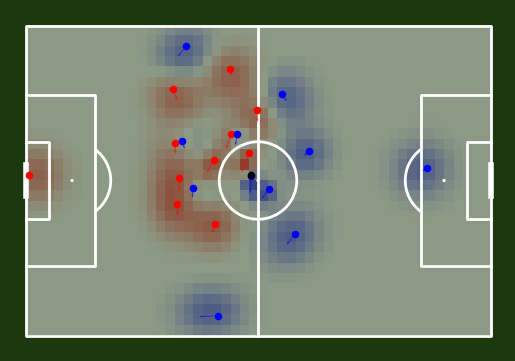

In [11]:
import matplotlib.pyplot as plt
f = 100

fig, ax = td_object.plot_players(frame=f, velocities=True)


ax.imshow(control[f].reshape(30,50),extent = (0,120, 0, 80), 
          cmap='bwr', alpha=0.5, vmin=0.0, vmax=1.0)


Current batch: 1/2
Current batch: 2/2


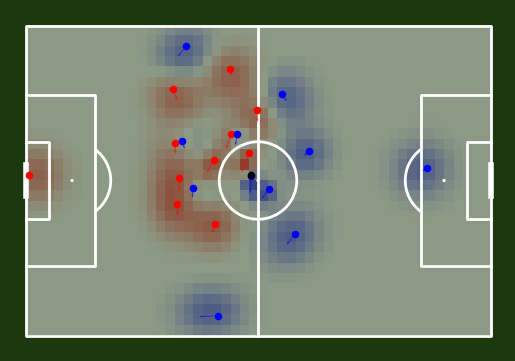

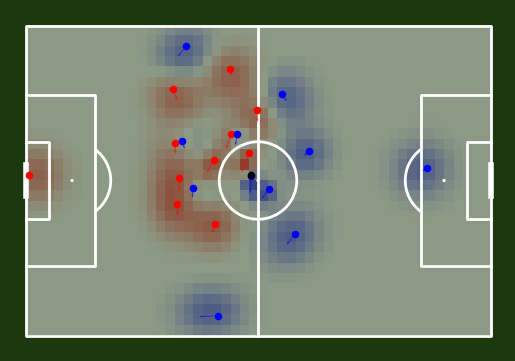

In [12]:
pi_co.plot_tensor_pitch_control(td_object=td_object, frame=100, version='Fernandez')

In [13]:
pi_co.animate_tensor_pitch_control(td_object=td_object, version='Fernandez', fname='Animation_Fernandez_0_100')

Current batch: 1/2
Current batch: 2/2
Generating your clip...
25.0% done!
50.0% done!
75.0% done!
All done!


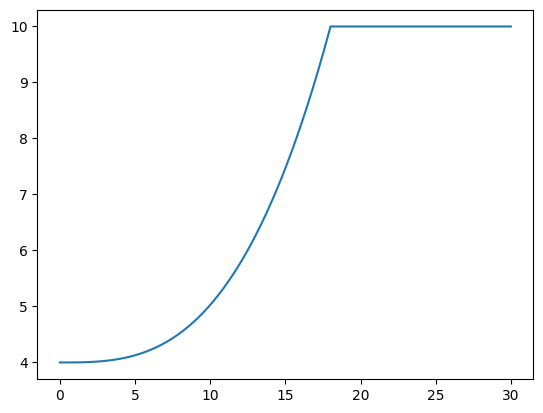

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def RI(distance_to_ball, exp=3, div=972):
    ri = np.min([4 + distance_to_ball**exp /div, 10])
    return ri

dtb = np.arange(0, 30, 0.01)
ris = [RI(x) for x in dtb]
plt.plot(dtb, ris)

In [ ]:
control[100]

In [ ]:
control.shape

In [ ]:
len(pitch_control.shape)